In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
subframe_size = 300
word_size = 30
word_data_size = 24
subframe_data_size = 240

In [3]:
bits = np.fromfile('navigation_bits.u8', dtype = 'uint8')

Detect subframe preamble by majority voting amongst the possible offsets.

In [4]:
preamble = np.array([1,0,0,0,1,0,1,1], dtype = 'uint8')
preamble_detect = np.where(np.abs(np.correlate(2*bits.astype('int')-1, 2*preamble.astype('int')-1)) == 8)[0]
preamble_offset = np.argmax(np.histogram(preamble_detect % subframe_size, bins = np.arange(0,subframe_size))[0])

In [5]:
subframes = bits[preamble_offset:]
subframes = subframes[:subframes.size//subframe_size*subframe_size].reshape((-1,subframe_size))
words = subframes.reshape((-1,word_size))

In [6]:
# Last bits from previous word, used for parity calculations
words_last = np.roll(words[:,-1], 1)
words_prelast = np.roll(words[:,-2], 1)

# Correct data using last bit from previous word
words_data = words[:, :word_data_size] ^ words_last.reshape((-1,1))
subframes_data = words_data.reshape((-1,subframe_data_size))

# Parity checks for each of the bits (0 means valid)
parity0 = np.bitwise_xor.reduce(words_data[:, np.array([1,2,3,5,6,10,11,12,13,14,17,18,20,23])-1], axis = 1) ^ words_prelast ^ words[:,word_data_size]
parity1 = np.bitwise_xor.reduce(words_data[:, np.array([2,3,4,6,7,11,12,13,14,15,18,19,21,24])-1], axis = 1) ^ words_last ^ words[:,word_data_size+1]
parity2 = np.bitwise_xor.reduce(words_data[:, np.array([1,3,4,5,7,8,12,13,14,15,16,19,20,22])-1], axis = 1) ^ words_prelast ^ words[:,word_data_size+2]
parity3 = np.bitwise_xor.reduce(words_data[:, np.array([2,4,5,6,8,9,13,14,15,16,17,20,21,23])-1], axis = 1) ^ words_last ^ words[:,word_data_size+3]
parity4 = np.bitwise_xor.reduce(words_data[:, np.array([1,3,5,6,7,9,10,14,15,16,17,18,21,22,24])-1], axis = 1) ^ words_last ^ words[:,word_data_size+4]
parity5 = np.bitwise_xor.reduce(words_data[:, np.array([3,5,6,8,9,10,11,13,15,19,22,23,24])-1], axis = 1) ^ words_prelast ^ words[:,word_data_size+5]

# Parity check for word
parity = parity0 | parity1 | parity2 | parity3 | parity4 | parity5

# Parity check for subframe
parity_subframe = np.any(parity.reshape((-1,subframe_size//word_size)), axis = 1)

Most subframes do not have valid parity, as shown below. We use a weaker heuristic, where only parity of TLM and HOW words are required to be valid. With this criterion, all the subframes are valid, except the first few and last subframes.

In [7]:
parity_subframe

array([ True,  True,  True,  True,  True,  True, False, False,  True,
        True,  True, False, False,  True,  True,  True, False, False,
        True,  True,  True, False, False,  True,  True,  True, False,
       False,  True,  True,  True, False, False,  True,  True,  True,
       False, False,  True,  True,  True, False, False,  True,  True,
        True, False, False,  True,  True,  True, False, False,  True,
        True,  True, False, False,  True,  True,  True, False, False,
        True,  True,  True, False, False,  True,  True,  True, False,
       False,  True,  True,  True, False, False,  True,  True,  True,
       False, False,  True,  True,  True, False, False,  True,  True,
        True, False, False,  True,  True,  True, False, False,  True,
        True,  True, False, False,  True,  True,  True, False, False,
        True,  True,  True, False, False,  True,  True,  True, False,
       False,  True,  True,  True, False, False,  True,  True,  True,
       False, False,

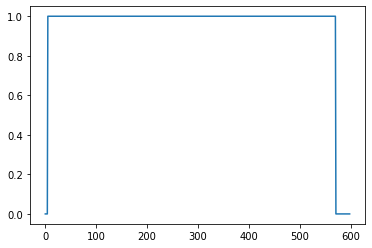

In [8]:
correct_frames = (parity[::10] == 0) & (parity[1::10] == 0)
plt.plot(correct_frames)

Analysis of the TOW in valid frames. It ranges between 298338 and 301728, corresponding to 10:52:18 and 11:48:48 on Wednesday (2019-06-26).

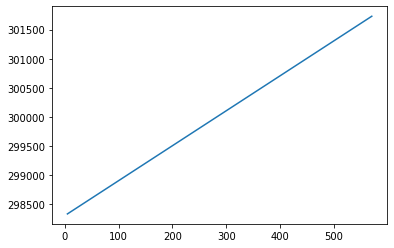

In [9]:
tow = np.sum(words_data[1::10,:17].astype('int') * 2**np.arange(16,-1,-1), axis = 1) * 6
plt.plot(np.arange(tow.size)[correct_frames], tow[correct_frames])

The subframe ID in the HOW word cycles as usual.

In [10]:
subframe_id = np.packbits(words_data[1::10,19:22], axis = 1).ravel() >> 5
subframe_id[correct_frames]

array([3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4,
       5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1,
       2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3,
       4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5,
       1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2,
       3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4,
       5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1,
       2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3,
       4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5,
       1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2,
       3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4,
       5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1,
       2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3,
       4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3,

Alert and anti-spoofing flags in the HOW word are not set.

In [11]:
np.any(words_data[1::10,17:19][correct_frames])

False

For subframes 1 (WN, health and clock), 2 and 3 (ephemeris), a filler of alternating 1's and 0's is transmitted in all the words after the HOW (including the parity bits). This makes parity invalid for these subframes.

In [12]:
filler_subframe = subframes[correct_frames & (subframe_id == 1), 60:][0,:]
filler_subframe

array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0],
      dtype=uint8)

In [13]:
np.any(subframes[correct_frames & (subframe_id <= 3), 60:] ^ filler_subframe, axis = 1)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [14]:
np.all(parity_subframe[correct_frames & (subframe_id <= 3)])

True

On the other hand, the parity for subframes 4 and 5 (almanacs) is correct.

In [15]:
np.all(parity_subframe[correct_frames & (subframe_id >= 4)])

False

Data ID field for subframes 4 and 5 has the nominal value 01.

In [16]:
np.any(subframes_data[correct_frames & (subframe_id >= 4), 2*word_data_size:2*word_data_size+2] ^ np.array([0,1]))

False

The SVID in subframes 4 and 5 follows the nominal schedule, except that SVID 4 has been replaced with 0 to indicate dummy SV. This is normal, since PRN 4 is not currently assigned. 

In [17]:
svid_subframe4 = np.packbits(subframes_data[correct_frames & (subframe_id == 4), 2*word_data_size+2:2*word_data_size+8], axis = 1).ravel() >> 2
svid_subframe5 = np.packbits(subframes_data[correct_frames & (subframe_id == 5), 2*word_data_size+2:2*word_data_size+8], axis = 1).ravel() >> 2

In [18]:
svid_subframe4

array([59, 57, 60, 61, 62, 63, 57, 25, 26, 27, 28, 57, 29, 30, 31, 32, 57,
       62, 52, 53, 54, 57, 55, 56, 58, 59, 57, 60, 61, 62, 63, 57, 25, 26,
       27, 28, 57, 29, 30, 31, 32, 57, 62, 52, 53, 54, 57, 55, 56, 58, 59,
       57, 60, 61, 62, 63, 57, 25, 26, 27, 28, 57, 29, 30, 31, 32, 57, 62,
       52, 53, 54, 57, 55, 56, 58, 59, 57, 60, 61, 62, 63, 57, 25, 26, 27,
       28, 57, 29, 30, 31, 32, 57, 62, 52, 53, 54, 57, 55, 56, 58, 59, 57,
       60, 61, 62, 63, 57, 25, 26, 27, 28, 57, 29], dtype=uint8)

In [19]:
svid_subframe5

array([20, 21, 22, 23, 24, 51,  1,  2,  3,  0,  5,  6,  7,  8,  9, 10, 11,
       12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 51,  1,  2,  3,
        0,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 51,  1,  2,  3,  0,  5,  6,  7,  8,  9, 10, 11, 12,
       13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 51,  1,  2,  3,  0,
        5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 51,  1,  2,  3,  0,  5,  6,  7], dtype=uint8)

For subframe 5, we omit the study of pages 1 through 24, which contain almanac data and we assume to be valid. We study page 25, which is marked by SVID 51 and contains SV health.

In [20]:
subframe5_page25 = subframes_data[correct_frames & (subframe_id == 5), :][svid_subframe5 == 51, :]

The t_oa and WN_a for page 25 correspond to times near the beginning and end of GPS week 2059.

In [21]:
toa = np.packbits(subframe5_page25[:,2*word_data_size+8:2*word_data_size+16], axis = 1).ravel().astype('int') * 2**12
wna = np.packbits(subframe5_page25[:,2*word_data_size+16:2*word_data_size+24], axis = 1).ravel() + 2048
toa

array([ 36864, 540672, 540672, 540672, 540672])

In [22]:
wna

array([2059, 2059, 2059, 2059, 2059], dtype=uint16)

SV health in subframe 5 page 25 indicates that all SV except SV 4 are healthy.

In [23]:
subframe5_page25[:,2*word_data_size+24:][:,:6*6*4:].reshape((-1,6*4,6))

array([[[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 

The anti-spoofing and SV configurations flags in subframe 4 page 25 indicate that AS is on for all SVs and different signal capabilities for different SVs.

In [24]:
subframe4_page25 = subframes_data[correct_frames & (subframe_id == 4), :][svid_subframe4 == 63, :]
anti_spoofing = subframe4_page25[:,2*word_data_size+8:][:,:32*4].reshape((-1,32,4))
anti_spoofing

array([[[1, 0, 1, 1],
        [1, 0, 0, 1],
        [1, 0, 1, 1],
        [1, 0, 1, 0],
        [1, 0, 1, 0],
        [1, 0, 1, 1],
        [1, 0, 1, 0],
        [1, 0, 1, 1],
        [1, 0, 1, 1],
        [1, 0, 1, 1],
        [1, 0, 0, 1],
        [1, 0, 1, 0],
        [1, 0, 0, 1],
        [1, 0, 0, 1],
        [1, 0, 1, 0],
        [1, 0, 0, 1],
        [1, 0, 1, 0],
        [1, 0, 0, 1],
        [1, 0, 0, 1],
        [1, 0, 0, 1],
        [1, 0, 0, 1],
        [1, 0, 0, 1],
        [1, 0, 0, 1],
        [1, 0, 1, 1],
        [1, 0, 1, 1],
        [1, 0, 1, 1],
        [1, 0, 1, 1],
        [1, 0, 0, 1],
        [1, 0, 1, 0],
        [1, 0, 1, 1],
        [1, 0, 1, 0],
        [1, 0, 1, 1]],

       [[1, 0, 1, 1],
        [1, 0, 0, 1],
        [1, 0, 1, 1],
        [1, 0, 1, 0],
        [1, 0, 1, 0],
        [1, 0, 1, 1],
        [1, 0, 1, 0],
        [1, 0, 1, 1],
        [1, 0, 1, 1],
        [1, 0, 1, 1],
        [1, 0, 0, 1],
        [1, 0, 1, 0],
        [1, 0, 0, 1],
        

The health flags in subframe 4 page 25 indicate that SV 25 to 32 are all healthy.

In [25]:
health = subframe4_page25[:,2*word_data_size+8+32*4+2:][:,:6*8].reshape((-1,8,6))
health

array([[[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 

Below we show t_oa for almanac entries in subframes 4 and 5.

In [26]:
np.packbits(subframes_data[correct_frames & (subframe_id == 5), :][svid_subframe5 <= 24, 3*word_data_size:3*word_data_size+8], axis = 1) * 2**12

array([[36864],
       [36864],
       [36864],
       [36864],
       [36864],
       [36864],
       [36864],
       [36864],
       [40960],
       [36864],
       [36864],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [40960],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [40960],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [

In [27]:
np.packbits(subframes_data[correct_frames & (subframe_id == 4), :][svid_subframe4 <= 32, 3*word_data_size:3*word_data_size+8], axis = 1) * 2**12

array([[36864],
       [36864],
       [36864],
       [36864],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384],
       [16384]], dtype=uint16)